In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import collections as c
import matplotlib.pyplot as plt
from operator import truediv

%matplotlib inline

In [4]:
df=pd.read_csv('../data/bbAllConvoLinesDFmore.csv',sep=';')

/home/mako0970/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (124,125,127,128,129,131,132,133,135,136,137,139,140,141,143,144,145,147,148,149,151,152,153,155,156,157,159,160,161,163,164,165,167,168,169,171,172,173,175,176,177,179,180,181,183,184,185,187,188,189,191,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
len(df)

10373

In [6]:
df.columns

Index([u'Unnamed: 0', u'id', u'username', u'user_id', u'geo_enabled',
       u'followCount', u'friendCount', u'faveCount', u'tweetCount', u'date',
       ...
       u'reply43OrigText', u'reply43OrigReplyWhat', u'reply43OrigReplyWho',
       u'dateObj', u'repSecDiff', u'repSet', u'lenRepSet', u'convNames',
       u'convStart', u'branchConvo'],
      dtype='object', length=203)

### Limit data to the time frame of analysis

In [7]:
df=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-10-15 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-23 00:00:00'))]

In [8]:
len(df)

8846

In [9]:
userEdgeList=df[['username', 'replyWho']]

In [10]:
weighted=userEdgeList.groupby(['username', 'replyWho']).size()

In [11]:
weighted.to_csv('../data/replyUserNetOverall.csv',sep=',', header=False, index=True)

In [12]:
before=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-10-15 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-10-25 00:00:00'))]

In [13]:
during=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-10-25 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-04 00:00:00'))]

In [14]:
after=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-11-04 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-14 00:00:00'))]

In [15]:
lafter=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-11-14 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-23 00:00:00'))]

In [16]:
bUserEdgeList=before[['username', 'replyWho']]

In [17]:
bWeighted=bUserEdgeList.groupby(['username', 'replyWho']).size()

In [18]:
bWeighted.to_csv('../data/replyUserNetBefore.csv',sep=',', header=False, index=True)

In [19]:
dUserEdgeList=during[['username', 'replyWho']]

In [20]:
dWeighted=dUserEdgeList.groupby(['username', 'replyWho']).size()

In [21]:
dWeighted.to_csv('../data/replyUserNetDuring.csv',sep=',', header=False, index=True)

In [22]:
aUserEdgeList=after[['username', 'replyWho']]

In [23]:
aWeighted=aUserEdgeList.groupby(['username', 'replyWho']).size()

In [24]:
aWeighted.to_csv('../data/replyUserNetAfter.csv',sep=',', header=False, index=True)

In [25]:
laUserEdgeList=lafter[['username', 'replyWho']]

In [26]:
laWeighted=laUserEdgeList.groupby(['username', 'replyWho']).size()

In [27]:
laWeighted.to_csv('../data/replyUserNetLafter.csv',sep=',', header=False, index=True)

## Overall network analysis

In [28]:
G=nx.read_weighted_edgelist('../data/replyUserNetOverall.csv',delimiter=',',create_using=nx.DiGraph())

In [29]:
len(G)

2755

In [30]:
G.number_of_edges()

3755

In [31]:
str_comps=nx.strongly_connected_component_subgraphs(G)

In [32]:
len(list(str_comps))

1865

In [33]:
weak_comps=nx.weakly_connected_component_subgraphs(G)

In [34]:
len(list(weak_comps))

1046

In [35]:
strong=sorted(nx.strongly_connected_component_subgraphs(G), key = len, reverse=True)

In [36]:
len(strong[0])

289

In [37]:
weak=sorted(nx.weakly_connected_component_subgraphs(G), key = len, reverse=True)

In [38]:
len(weak[0])

992

In [39]:
len(weak[0])/float(len(G))

0.3600725952813067

In [40]:
len(strong[0])/float(len(G))

0.10490018148820326

**Takeway:**
* More than one third of the local users talk to each other in some way (over the whole time period)
* 10% of the local users talk to each other so you can get to them from one reply to another
* Considering that these are replies (not mentions, not RTs) - this is pretty remarkable

In [41]:
degree=nx.degree(G)

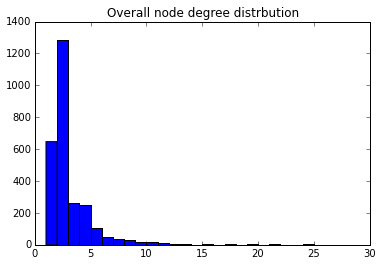

In [42]:
plt.hist(degree.values(), max(degree.values())-1)
plt.xlim(xmax=30)
plt.title('Overall node degree distrbution')

* While the highest degree is 80 (cut off), overall this is not super long-tailed
* Also really interesting that the highest peak is 2
* So most local users talk to 2 other local users
* And then it looks a bit step-wise (noise?)

### Incorporate  edge weights into the degree distribution

In [43]:
A=nx.adjacency_matrix(G)
strength=np.array(A.sum(axis=1)).reshape(-1) + np.array(A.sum(axis=0)).reshape(-1)

/home/mako0970/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


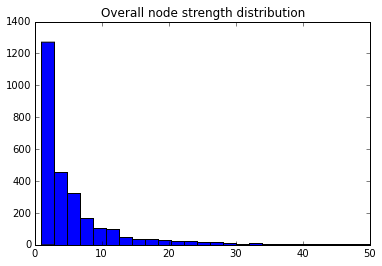

In [44]:
plt.hist(strength, 125)
plt.xlim(xmax=50)
plt.title('Overall node strength distribution')

**The order of degree sequence and the order of the nodes in the adjacency matrix (nodelist) are different!!!!!**

In [45]:
nodelist=G.nodes()

In [46]:
# REORDER the degree sequence to match the nodelist
from collections import OrderedDict
orderedDegree=OrderedDict((n, degree[n]) for n in nodelist)

/home/mako0970/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


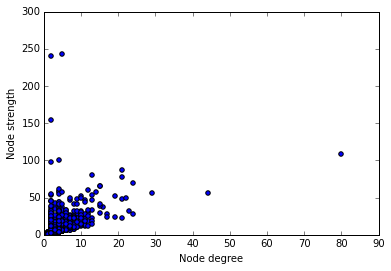

In [47]:
plt.scatter(orderedDegree.values(), strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Node degree')
plt.ylabel('Node strength')

In [48]:
degree.keys()[degree.values().index(80)]

u'NYCMayorsOffice'

In [49]:
nodelist.index('NYCMayorsOffice')

1388

In [50]:
strength[1388]

108.0

In [51]:
degree.keys()[degree.values().index(44)]

u'patkiernan'

In [52]:
nodelist.index('patkiernan')

2621

In [53]:
strength[2621]

56.0

**Takeways:**
* So the really frequent interactions happen to the low-degree users - few high-frequency conversation partners
* But then there is a diagonal trend - the bigger degree the bigger the strength
* So for the buld of users, their interactions are more or less evenly distributed across their contacts
* Say, 5 interactions per contact on average - adds up to a diagonal trend
* And most volume is concetrated at the origin - most people have few friends and don't talk to them too often
* And then there is NYCMayorsOffice - with 80 contacts and 108 conversations across them
* We know that 10 people responded to the cancelling marathon tweet
* People respond to it often! Not a single original tweet by it in our set
* The other extremish case is Pat Kiernan - the morning anchor for NY1
* He has 9 originals (or responses to others) and 47 replies to him - most are event-related

In [54]:
ratio=[x/y for x, y in zip(strength.tolist(), orderedDegree.values())]

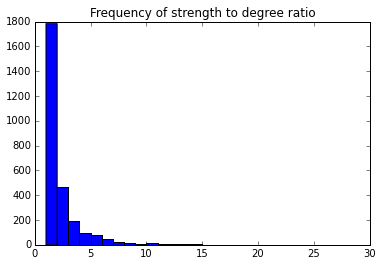

In [55]:
plt.hist(ratio, 119)
plt.xlim(xmax=30)
plt.title('Frequency of strength to degree ratio')

In [159]:
np.median(ratio)

1.1666666666666667

In [56]:
ratio.index(120)

743

In [57]:
nodelist[743]

u'Megglezzz'

In [58]:
degree['Megglezzz']

2

In [59]:
G['Megglezzz']

{u'DDougyy': {'weight': 117.0}}

In [60]:
G['DDougyy']

{u'Megglezzz': {'weight': 123.0},
 u'MrXiphoid': {'weight': 1.0},
 u'Rach716': {'weight': 1.0}}

**Takeways:**
* Long tailed
* Vast majority of people have on average one interaction with each contact
* Sizable portion has two on average
* And then there are people in the tail - max is 120
* That's Megglezzz, who only talks to DDougyy (117 times) and he responds (123 times)
* They also have the longest conversation (43 steps) - teenagers at the time
* Can look at people **who have high weights** - commintment to their friend

### In- and Out-degree and Strength Distributions

#### In-degree

In [61]:
indeg=G.in_degree()

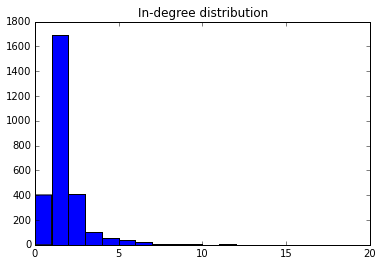

In [62]:
plt.hist(indeg.values(),max(indeg.values()))
plt.xlim(xmax=20)
plt.title('In-degree distribution')

In [63]:
in_strength=np.array(A.sum(axis=0)).reshape(-1)

In [64]:
A.sum(axis=0)

matrix([[ 1.,  1.,  1., ...,  1.,  8.,  2.]])

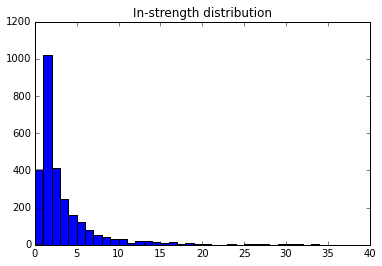

In [65]:
plt.hist(in_strength,max(in_strength))
plt.xlim(xmax=40)
plt.title('In-strength distribution')

In [66]:
# REORDER the in_degree sequence to match the nodelist
ordInDegree=OrderedDict((n, indeg[n]) for n in nodelist)

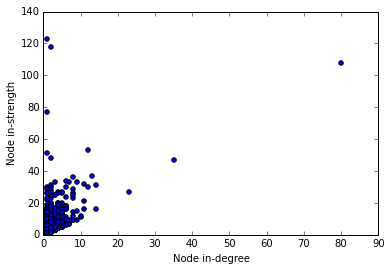

In [67]:
plt.scatter(ordInDegree.values(), in_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Node in-degree')
plt.ylabel('Node in-strength')

In [68]:
indeg.keys()[indeg.values().index(35)]

u'patkiernan'

In [171]:
in_ratio=[x/y if y!=0 else 1 for x, y in zip(in_strength.tolist(), ordInDegree.values())]

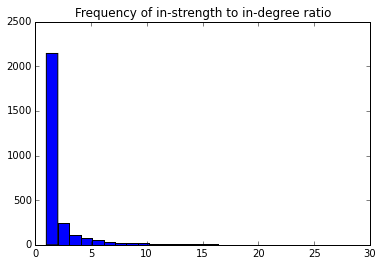

In [172]:
plt.hist(in_ratio, 119)
plt.xlim(xmax=30)
plt.title('Frequency of in-strength to in-degree ratio')

In [173]:
np.median(in_ratio)

1.0

**Takways:**
* So most people are replied to by two friends
* And for in-strength(unlike overall), two is also the highest peak
* This means most users have to interactions, on average one per friend
* There is still a very clear diagonal effect in the in-strength to in-degree ratio
* This means that most users have about equal number of interactions and friends - so on avg one per friend
* And then there are people on the left, being frequently resoponded to by a few firends
* And the NYCMayorOffice, that received 120 replies from 80 different users
* And Pat Kiernan who got 40 smth responses from 35 users

#### Out-degree

In [69]:
outdeg=G.out_degree()

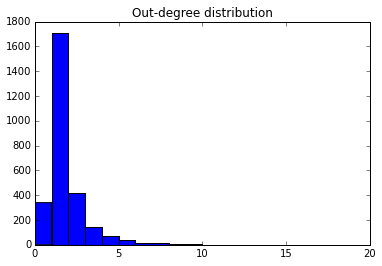

In [70]:
plt.hist(outdeg.values(),max(outdeg.values()))
plt.xlim(xmax=20)
plt.title('Out-degree distribution')

In [71]:
out_strength=np.array(A.sum(axis=1)).reshape(-1)

In [72]:
A.sum(axis=1)

matrix([[  0.],
        [  1.],
        [  0.],
        ..., 
        [  1.],
        [ 11.],
        [  2.]])

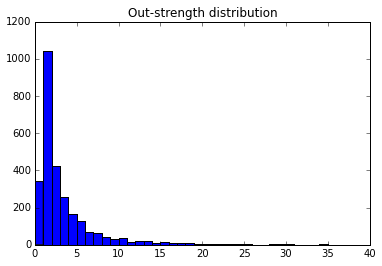

In [73]:
plt.hist(out_strength,max(out_strength))
plt.xlim(xmax=40)
plt.title('Out-strength distribution')

In [74]:
# REORDER the out_degree sequence to match the nodelist
ordOutDegree=OrderedDict((n, outdeg[n]) for n in nodelist)

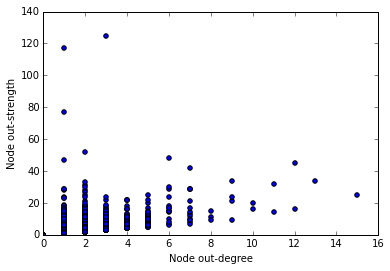

In [75]:
plt.scatter(ordOutDegree.values(), out_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Node out-degree')
plt.ylabel('Node out-strength')

In [168]:
out_ratio=[x/y if y!=0 else 1 for x, y in zip(out_strength.tolist(), ordOutDegree.values())]

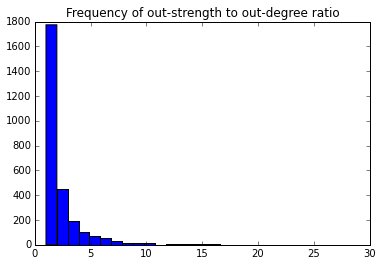

In [169]:
plt.hist(out_ratio, 119)
plt.xlim(xmax=30)
plt.title('Frequency of out-strength to out-degree ratio')

In [170]:
np.median(out_ratio)

1.0

**Takeways:**
* Our data set is biased towards the in-degree, because in includes replies, including the repliedWho
* But we don't alway have the outgoing tweets for those repliedWho users, since they might not been local
* Though we only include replies to other relevant-user tweets, so those outgoing tweets wouldn't be excluded cause they belong to an irrelevant user
* Should I supplement the user list from the global file?
* But all those users show up at the origin - the other pattern is unbiased (if we had the user, we'd have all their out replies)
* So we still have those couple users who reply a bunch to a handful of friends
* But the rest stay under 60 throghout the degree distribution
* This suggests that people have various degree of engagement with their friends, pretty much regardless to how many friends they reply to - but mostly users don't reply too often (more than 60 times)
* The slight diagonal trend (very low) suggests that besides those few users who answer a lot to few friends, most people produce a consistent number of replies to their friends, no matter how many 

#### Weight distribution

In [76]:
weights=nx.get_edge_attributes(G,'weight').values()

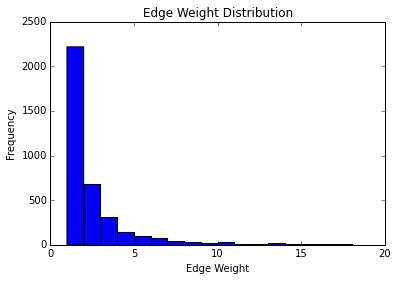

In [82]:
plt.hist(weights, max(weights)-1)
plt.xlim(xmax=20)
plt.ylim(ymin=0)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Edge Weight Distribution')

* Long tailed
* Not surprising

### Reciprocity, transitivity, assortativity

In [89]:
nx.diameter(strong[0])

24

In [87]:
nx.diameter(nx.Graph(weak[0]))

25

* Diameter of 24 for strongly connected component of 289 - directed (undirected diam=15)
* Diameter of 25 for weakly connected component of 992 - not

In [90]:
reciprocity=sum([G.has_edge(e[1], e[0]) for e in G.edges_iter()])/float(G.number_of_edges())

In [91]:
reciprocity

0.7091877496671105

**Takeaways:**
* High reciprocity
* Makes sense considering it's a reply
* Still, there are many situations where people reply to celbrities and officials (NYCMayorOffice)
* This means that in this dataset most replies are part of actual conversation between equals (wrt status)
* We can see how the number of followers affects the reciprocity rate
* Also see how reciprocity changes over time slices

In [92]:
trans=nx.transitivity(G)

In [93]:
trans

0.09372436423297785

* Low transitivity
* If I reply to you, and you reply to Steve, I very rarely will reply to Steve also
* The conversational relationships do not spread
* We can also DO TRANSITIVE TRIPLE correction for directed graphs (RT paper code)

In [94]:
assort=nx.degree_assortativity_coefficient(G)

In [95]:
assort

0.049627722127603552

In [96]:
in_assort=nx.degree_assortativity_coefficient(G,x='in',y='in')

In [97]:
in_assort

-0.012704861987499915

In [98]:
out_assort=nx.degree_assortativity_coefficient(G,x='out',y='out')

In [99]:
out_assort

0.33063179123366204

In [100]:
oi_assort=nx.degree_assortativity_coefficient(G,x='out',y='in')

In [101]:
oi_assort

0.049627722127603552

In [102]:
io_assort=nx.degree_assortativity_coefficient(G,x='in',y='out')

In [103]:
io_assort

0.30651852228693982

**Takeways:**
* Overall assortativity is positive but very low
* So no strong relationship/clustering among people who reply and replied to a lot and others like them
* The directed assortativity versions are more illuminating
* Users who reply a lot are often connected to other users who reply a lot - we have these replying pairs
* But also users who are replied to a lot a connected to people who reply a lot

### Weighted assortativity

In [139]:
intWeights={key:int(round(val,0)) for key, val in nx.get_edge_attributes(G, 'weight').items()}

In [140]:
nx.set_edge_attributes(G,'weight', intWeights)

In [141]:
wassort=nx.degree_assortativity_coefficient(G, weight='weight')

In [142]:
wassort

0.17415588300153431

In [143]:
in_wassort=nx.degree_assortativity_coefficient(G,x='in',y='in', weight='weight')

In [144]:
in_wassort

0.13683312951510096

In [145]:
out_wassort=nx.degree_assortativity_coefficient(G,x='out',y='out', weight='weight')

In [146]:
out_wassort

0.44438236978101547

In [148]:
oi_wassort=nx.degree_assortativity_coefficient(G,x='out',y='in', weight='weight')

In [149]:
oi_wassort

0.17415588300153431

In [150]:
io_wassort=nx.degree_assortativity_coefficient(G,x='in',y='out', weight='weight')

In [151]:
io_wassort

0.45401137208980469

**Takeway:**
* The assortative trends are even stronger (a bit) when we account for edge weights
* So people with high out-strength reply to other people with high out-strength
* This means that people who either reply to many people or reply to their friends often tend to reply to others like that
* And people with high out-strength reply to people with high in-strength
* This means that people who are either replied to by many people or thier friends reply to them often tend to be replied to by other users who reply to either many or frequently

### Assortativity on being a conversationalist (in and out-ratio >1)

In [196]:
freqInTalk={key:True if r>1 else False for key, r in zip(ordInDegree.keys(),in_ratio)}

In [197]:
nx.set_node_attributes(G,'highInRatio',freqInTalk)

In [198]:
freqOutTalk={key:True if r>1 else False for key, r in zip(ordOutDegree.keys(),out_ratio)}

In [199]:
nx.set_node_attributes(G,'highOutRatio',freqOutTalk)

In [200]:
nx.attribute_assortativity_coefficient(G, 'highInRatio')

0.4331932740505663

In [201]:
nx.attribute_assortativity_coefficient(G, 'highOutRatio')

0.480736487596044

In [205]:
bothFreqTalk={key:True if (i>1) & (o>1) else False for key,i,o in zip(ordInDegree.keys(),in_ratio,out_ratio)}

In [206]:
nx.set_node_attributes(G,'highBothRatios',bothFreqTalk)

In [207]:
nx.attribute_assortativity_coefficient(G, 'highBothRatios')

0.6084399098536077

**Takeways:**
* People who reply more than once on average to all their friends tend to talk to others like them
* People who are replied by their friends on average more than once tend to talk to other liken them
* And users who both reply and are replied by their friends on average more than once are VERY likely to talk to
others like then
* So frequent conversation is a two-way street
* CHECK with CONFIGURATION MODEL

### Centrality

In [211]:
sorted(nx.closeness_centrality(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'RickWebb', 0.20930232558139536),
 (u'steketee', 0.20382165605095542),
 (u'JamesDeanX', 0.2028169014084507),
 (u'arainert', 0.19766643788606725),
 (u'tonybgoode', 0.19341840161182),
 (u'af', 0.19290020093770932),
 (u'kristalberg', 0.1893491124260355),
 (u'harryh', 0.18872870249017037),
 (u'noneck', 0.18835840418574232),
 (u'caro', 0.18811234487263226),
 (u'dN0t', 0.18725617685305593),
 (u'Jmodio', 0.1867704280155642),
 (u'Shaila', 0.18664938431626701),
 (u'mbaratz', 0.18520900321543407),
 (u'BaconSeason', 0.18308963763509217),
 (u'cfohlin', 0.1819330385344283),
 (u'janatrantow', 0.18181818181818182),
 (u'kingsleyharris', 0.181360201511335),
 (u'helloericho', 0.180564263322884),
 (u'ckurdziel', 0.18045112781954886),
 (u'Stwo', 0.18045112781954886),
 (u'ModernUrbanLife', 0.179215930304916),
 (u'alexmiz', 0.17899316345556246),
 (u'tmilewski', 0.17899316345556246),
 (u'april_conyers', 0.17888198757763976),
 (u'smart', 0.17843866171003717),
 (u'joshspear', 0.1782178217821782),
 (u'JorgeO

In [213]:
sorted(nx.betweenness_centrality(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'caro', 0.25216263075867196),
 (u'Jmodio', 0.22640764774310457),
 (u'patkiernan', 0.20550280379999494),
 (u'af', 0.1975842915242082),
 (u'RickWebb', 0.16132318218694758),
 (u'Shaila', 0.1538011190995098),
 (u'arainert', 0.14822240537907985),
 (u'SimsJames', 0.1406246360024669),
 (u'kendrad', 0.13817036736062568),
 (u'katologic', 0.12372729881817215),
 (u'saschasegan', 0.11362203417952546),
 (u'binghott', 0.10769968302361595),
 (u'tonybgoode', 0.10767061994575859),
 (u'FrankRamblings', 0.10337525310485532),
 (u'Stwo', 0.10101298319604948),
 (u'geofffox', 0.09501047370167578),
 (u'gwhizkids', 0.09418865107018412),
 (u'JesseCFriedman', 0.09393271325570285),
 (u'jeffchatterton', 0.09215771589801229),
 (u'ikebrooker', 0.08401877123929968),
 (u'alexmiz', 0.08317673075026547),
 (u'cfohlin', 0.08280596466325843),
 (u'a0k', 0.08247302742291038),
 (u'mbaratz', 0.07502926044137714),
 (u'TimeOutNewYork', 0.07410214989338103),
 (u'DamianDazz', 0.06874487345751308),
 (u'gregmocker', 0.06738433142

In [214]:
sorted(nx.eigenvector_centrality(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'neiki2u', 0.49631236569599535),
 (u'caitiecoll', 0.4782051152716978),
 (u'chenyanqing', 0.4588408823046921),
 (u'ellactricitee', 0.3876712170186493),
 (u'LukeKingma', 0.3265848613982305),
 (u'ricenbeats', 0.16419258384218507),
 (u'MalbecBen', 0.10788438301544617),
 (u'gangsta_leen', 0.10306886626368689),
 (u'jessehutchison', 0.057141662642730705),
 (u'SeanValjean', 0.05013401418673682),
 (u'elisebartlett', 0.03809444176182047),
 (u'a0k', 0.019936247888095154),
 (u'krysXtyna', 0.019311376991934734),
 (u'jasonkeath', 0.015012966652573073),
 (u'Chefbriduff', 0.006301296819863708),
 (u'twatan', 0.003499513371161888),
 (u'BaconSeason', 0.0022903587024515515),
 (u'KimberlyAnneR', 0.0017824175300187196),
 (u'alexmiz', 0.001019551989262192),
 (u'lloyd_says', 0.0009401642399408083),
 (u'Thomas_Wendt', 0.0007725250711423127),
 (u'Jmodio', 0.0006564574741831005),
 (u'Stwo', 0.0006557754373114142),
 (u'harryh', 0.0006475468570091656),
 (u'JorgeO', 0.0004892686419462507),
 (u'DeidreDoom', 0.000

In [215]:
sorted(nx.pagerank(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'patkiernan', 0.01917195806434515),
 (u'harryh', 0.01775843839273613),
 (u'Jmodio', 0.015030476371480977),
 (u'EricCarvin', 0.01484367979408208),
 (u'gregmocker', 0.013107410689166252),
 (u'RickWebb', 0.012051745297638578),
 (u'tonybgoode', 0.011757790481352316),
 (u'arainert', 0.011266349468459317),
 (u'geofffox', 0.010344257978153084),
 (u'caro', 0.009881962552500092),
 (u'JorgeO', 0.009790899343410308),
 (u'DeidreDoom', 0.009483730788564713),
 (u'buritica', 0.00913959744177275),
 (u'SteveScottWCBS', 0.009054867350110234),
 (u'rich1', 0.008069268323024197),
 (u'af', 0.008014734923249977),
 (u'JesseCFriedman', 0.007972017895314487),
 (u'chenyanqing', 0.00796985229201277),
 (u'sd', 0.007690067304820796),
 (u'frankmorano', 0.007465010668660272),
 (u'BobbyTBD', 0.007455066945301258),
 (u'ellactricitee', 0.007448023650548932),
 (u'cdessi', 0.007311909995176457),
 (u'sjkaliski', 0.007299678641896642),
 (u'MallorieRose', 0.007238462995460989),
 (u'neiki2u', 0.007170810157306489),
 (u'ero